# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [1]:
import pyLDAvis.gensim_models

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 20000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (20000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(19354, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

96.77

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(19354, 10)


1    16339
0     3015
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
I received this box with great anticipation since they don't sell these on the west coast. I got the package, opened the box and was EXTREMELY disappointed. The cookies looked like a gorilla shook the box to death and left most of the box filled with crumbs. AND THERE WAS A RODENT SIZED HOLE ON THE SIDE OF THE BOX!!!!!!!! So, needless to say I will not NOT be reordering these again.
I have two cats. My big boy has eaten these and never had a problem...as a matter of fact he has never vomited or had a hair ball since I adopted him at 2 months. My girl cat throws up every time she eats this particular flavor. Since I treat them equally these are no longer purchased. I hate to see my girl sick so I just recommend you watch your cats after you give them these treats. If not a problem...carry on.
I was always a fan of Dave's, so I bought this at a local store to try Blair's and I'm glad I did.  The jalepeno saus

In [18]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!


In [19]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
I received this box with great anticipation since they don't sell these on the west coast. I got the package, opened the box and was EXTREMELY disappointed. The cookies looked like a gorilla shook the box to death and left most of the box filled with crumbs. AND THERE WAS A RODENT SIZED HOLE ON THE SIDE OF THE BOX!!!!!!!! So, needless to say I will not NOT be reordering these again.
I have two cats. My big boy has eaten these and never had a problem...as a matter of fact he has never vomited or had a hair ball since I adopted him at 2 months. My girl cat throws up every time she eats this particular flavor. Since I treat them equally these are no longer purchased. I hate to see my girl sick so I just recommend you watch your cats after you give them these treats. If not a problem...carry on.
I was always a fan of Dave's, so I bought this at a local store to try Blair's and I'm glad I did.  The jalepeno saus

In [20]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [21]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I have two cats. My big boy has eaten these and never had a problem...as a matter of fact he has never vomited or had a hair ball since I adopted him at 2 months. My girl cat throws up every time she eats this particular flavor. Since I treat them equally these are no longer purchased. I hate to see my girl sick so I just recommend you watch your cats after you give them these treats. If not a problem...carry on.


In [22]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

We have used the Victor fly bait for  seasons.  Can't beat it.  Great product!


In [23]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I have two cats My big boy has eaten these and never had a problem as a matter of fact he has never vomited or had a hair ball since I adopted him at 2 months My girl cat throws up every time she eats this particular flavor Since I treat them equally these are no longer purchased I hate to see my girl sick so I just recommend you watch your cats after you give them these treats If not a problem carry on 


In [24]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [25]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 19354/19354 [00:07<00:00, 2733.71it/s]


In [24]:
preprocessed_reviews[1500]

'two cats big boy eaten never problem matter fact never vomited hair ball since adopted months girl cat throws every time eats particular flavor since treat equally no longer purchased hate see girl sick recommend watch cats give treats not problem carry'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [292]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [293]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaawwwwwwwwww', 'aaaaah', 'aaaand']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (46071, 39364)
the number of unique words  39364


## [4.2] Bi-Grams and n-Grams.

In [294]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (46071, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [295]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able chew', 'able drink', 'able eat', 'able enjoy', 'able feed', 'able figure', 'able find']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (46071, 27311)
the number of unique words including both unigrams and bigrams  27311


## [4.4] Word2Vec

In [296]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [297]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8248318433761597), ('terrific', 0.800858736038208), ('fantastic', 0.8005023002624512), ('excellent', 0.7830071449279785), ('amazing', 0.7823095321655273), ('good', 0.7785084247589111), ('perfect', 0.7366109490394592), ('wonderful', 0.7001661658287048), ('decent', 0.6842605471611023), ('fabulous', 0.6313499212265015)]
[('greatest', 0.7344785332679749), ('best', 0.7166743278503418), ('experienced', 0.6994856595993042), ('nastiest', 0.6855201721191406), ('closest', 0.6805672645568848), ('tastiest', 0.6763412356376648), ('awful', 0.6444735527038574), ('ive', 0.6347653269767761), ('hottest', 0.6314700245857239), ('eaten', 0.6301442384719849)]


In [298]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12798
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'available', 'victor', 'traps', 'unreal', 'course', 'total', 'fly', 'pretty', 'stinky', 'right', 'nearby', 'used', 'bait', 'seasons', 'ca', 'not', 'beat', 'great']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [299]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 46071/46071 [01:00<00:00, 758.63it/s] 

46071
50


#### [4.4.1.2] TFIDF weighted W2v

In [300]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [301]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 46071/46071 [09:43<00:00, 79.00it/s] 


# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [302]:
# Please write all the code with proper documentation

In [303]:
labels = final['Score'] 
df = labels
X=preprocessed_reviews
y = np.array(df)

In [304]:
from sklearn import cross_validation
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)



In [305]:
count_vect = CountVectorizer() #in scikit-learn
bow_X_tr=count_vect.fit_transform(X_1)
bow_X_test=count_vect.transform(X_test)

In [306]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
auc_test=[]
auc_train=[]
k_bow=list(range(1,30,3))
for i in k_bow:
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i, algorithm='brute')

    # fitting the model on crossvalidation train
    knn.fit(bow_X_tr, y_1)
   
    pred_test = knn.predict_proba(bow_X_test)[:,1]
    auc_test.append(roc_auc_score(y_test,pred_test))
    auc_test_bow=(roc_auc_score(y_test,pred_test))
    pred_train=knn.predict_proba(bow_X_tr)[:,1]
    auc_train_bow=(roc_auc_score(y_1,pred_train))
    auc_train.append(roc_auc_score(y_1,pred_train))
    print("\n K  value: ",i, "AUC Test: ",auc_test_bow," AUC Train ",auc_train_bow)
    
    


 


 K  value:  1 AUC Test:  0.5895170546812258  AUC Train  0.999626238086339

 K  value:  4 AUC Test:  0.641135997231305  AUC Train  0.9042904930173652

 K  value:  7 AUC Test:  0.6512856248989279  AUC Train  0.8628964375048139

 K  value:  10 AUC Test:  0.6531750195863517  AUC Train  0.8380391615999749

 K  value:  13 AUC Test:  0.6491683954634798  AUC Train  0.8212037497249206

 K  value:  16 AUC Test:  0.6489854687822276  AUC Train  0.8073748889382552

 K  value:  19 AUC Test:  0.6486598419505768  AUC Train  0.7961132999115313

 K  value:  22 AUC Test:  0.6474088507846544  AUC Train  0.7875795593669691

 K  value:  25 AUC Test:  0.6484930983564495  AUC Train  0.7812502192888022

 K  value:  28 AUC Test:  0.6503326722542243  AUC Train  0.7754722989243792


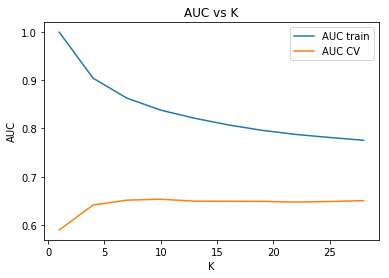

In [307]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(k_bow, auc_train, label='AUC train')
ax.plot(k_bow, auc_test, label='AUC CV')
plt.title('AUC vs K')
plt.xlabel('K')
plt.ylabel('AUC')
ax.legend()
plt.show()

In [ ]:
best_k_bow=22
knn_bow_22 = KNeighborsClassifier(n_neighbors=best_k_bow,n_jobs=-1)
knn_bow_22.fit(bow_X_tr, y_1)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=22, p=2,
           weights='uniform')

In [ ]:
predictions_bow_test=knn_bow_22.predict(bow_X_test)
predictions_bow_train=knn_bow_22.predict(bow_X_tr)
predict_bow_test=knn_bow_22.predict_proba(bow_X_test)
predict_train_bow=knn_bow_22.predict_proba(bow_X_tr)



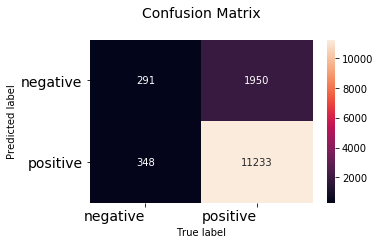

In [ ]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, predictions_bow_test), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

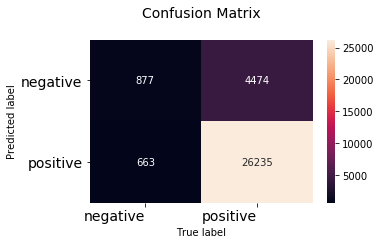

In [ ]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_1, predictions_bow_train), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

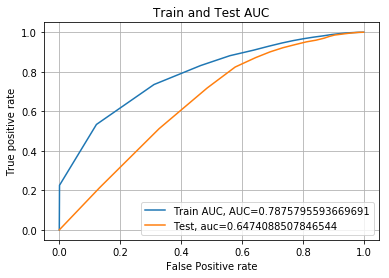

In [ ]:
fpr1, tpr1, _ = metrics.roc_curve(y_1, predict_train_bow[:,1])
#df = pd.DataFrame(dict(fpr=fpr1, tpr=tpr1))
auc_bow_train = metrics.auc(fpr1,tpr1)

fpr2, tpr2, _ = metrics.roc_curve(y_test,  predict_bow_test[:,1])
#df1 = pd.DataFrame(dict(fpr=fpr2, tpr=tpr2))
auc_bow_test = metrics.auc(fpr2,tpr2)


plt.plot(fpr1,tpr1,label="Train AUC, AUC="+str(auc_bow_train))
plt.plot(fpr2,tpr2,label="Test, auc="+str(auc_bow_test))
plt.legend(loc=4)




plt.title("Train and Test AUC")
plt.grid()
plt.xlabel('False Positive rate')
plt.ylabel('True positive rate')
plt.show


### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [ ]:
# Please write all the code with proper documentation

In [ ]:
labels = final['Score'] 
df = labels
X=preprocessed_reviews
y = np.array(df)

In [ ]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
tf_idf_vect = TfidfVectorizer()
tf_X_tr=tf_idf_vect.fit_transform(X_1)
tf_X_test=tf_idf_vect.transform(X_test)

In [ ]:
auc_test_tf=[]
auc_train_tf=[]
k_tf=list(range(1,30,3))
for i in k_tf:
    # instantiate learning model (k = 30)
    knn_tf = KNeighborsClassifier(n_neighbors=i, algorithm='brute')

    # fitting the model on crossvalidation train
    knn_tf.fit(tf_X_tr, y_1)
    pred_test_tf = knn_tf.predict_proba(tf_X_test)[:,1]
    auc_test_tf.append(roc_auc_score(y_test,pred_test_tf))
    auc_test_tf_V=(roc_auc_score(y_test,pred_test_tf))
    pred_train_tf=knn_tf.predict_proba(tf_X_tr)[:,1]
    auc_train_tf_v=(roc_auc_score(y_1,pred_train_tf))
    auc_train_tf.append(roc_auc_score(y_1,pred_train_tf))
    
    
 #   print("\n K  value: ",i, "AUC Test: ",auc_test_bow," AUC Train ",auc_train_bow)
    print("\n K  value: ",i, "AUC Test: ",auc_test_tf_v," AUC Train ",auc_train_tf_v)



 K  value:  1 AUC Test:  0.5107593782516815  AUC Train  0.999626238086339

 K  value:  4 AUC Test:  0.5107593782516815  AUC Train  0.9364605545769167

 K  value:  7 AUC Test:  0.5107593782516815  AUC Train  0.8882531395312919

 K  value:  10 AUC Test:  0.5107593782516815  AUC Train  0.856075362479787

 K  value:  13 AUC Test:  0.5107593782516815  AUC Train  0.8310820111425739

 K  value:  16 AUC Test:  0.5107593782516815  AUC Train  0.8125200104288717

 K  value:  19 AUC Test:  0.5107593782516815  AUC Train  0.799090267420688

 K  value:  22 AUC Test:  0.5107593782516815  AUC Train  0.7853638132019161

 K  value:  25 AUC Test:  0.5107593782516815  AUC Train  0.776853507465421

 K  value:  28 AUC Test:  0.5107593782516815  AUC Train  0.7688834251209387


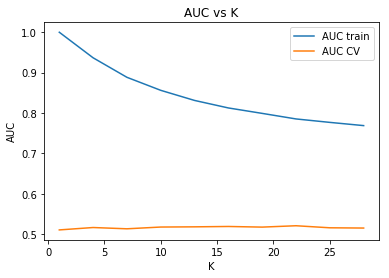

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(k_bow, auc_train_tf, label='AUC train')
ax.plot(k_bow, auc_test_tf, label='AUC CV')
plt.title('AUC vs K')
plt.xlabel('K')
plt.ylabel('AUC')
ax.legend()
plt.show()

In [ ]:
best_k_tf=13
knn_tf_13 = KNeighborsClassifier(n_neighbors=best_k_bow,n_jobs=5)
knn_tf_13.fit(tf_X_tr, y_1)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=5, n_neighbors=22, p=2,
           weights='uniform')

In [ ]:
predictions_tf_test=knn_tf_13.predict(tf_X_test)
predictions_tf_train=knn_tf_13.predict(tf_X_tr)
predict_tf_test=knn_tf_13.predict_proba(tf_X_test)
predict_tf_train=knn_tf_13.predict_proba(tf_X_tr)

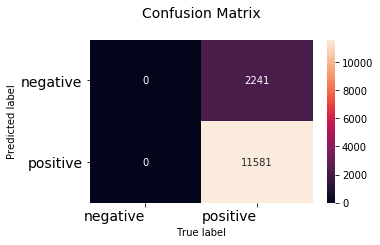

In [ ]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, predictions_tf_test), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

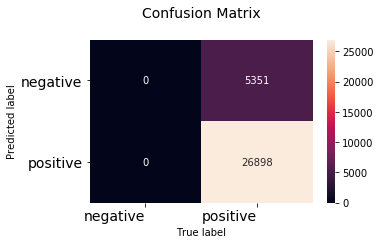

In [ ]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_1, predictions_tf_train), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

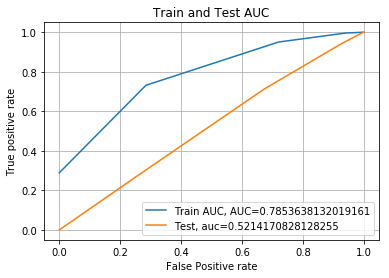

In [ ]:
fpr1, tpr1, _ = metrics.roc_curve(y_1, predict_tf_train[:,1])

auc_tf_train = metrics.auc(fpr1,tpr1)

fpr2, tpr2, _ = metrics.roc_curve(y_test,  predict_tf_test[:,1])

auc_tf_test = metrics.auc(fpr2,tpr2)

plt.plot(fpr1,tpr1,label="Train AUC, AUC="+str(auc_tf_train))
plt.plot(fpr2,tpr2,label="Test, auc="+str(auc_tf_test))
plt.legend(loc=4)
plt.title("Train and Test AUC")
plt.grid()
plt.xlabel('False Positive rate')
plt.ylabel('True positive rate')
plt.show

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [ ]:
# Please write all the code with proper documentation

In [49]:
i=0
list_of_sentance_train=[]
for sentance in X_1:
    list_of_sentance_train.append(sentance.split())

i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())  
    
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [50]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8217675089836121), ('excellent', 0.806664228439331), ('wonderful', 0.8055329322814941), ('good', 0.8007376194000244), ('fantastic', 0.7953416705131531), ('amazing', 0.7830697298049927), ('perfect', 0.7209258675575256), ('delicious', 0.7204991579055786), ('decent', 0.6994705200195312), ('quick', 0.6812461614608765)]
[('hooked', 0.8402969241142273), ('addicted', 0.8276816606521606), ('closest', 0.809531569480896), ('world', 0.8033856153488159), ('personal', 0.79764723777771), ('wow', 0.7925351858139038), ('britt', 0.7914252281188965), ('awful', 0.7901030778884888), ('disappointing', 0.7895898818969727), ('jamaica', 0.789070725440979)]


In [51]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:10])

number of words that occured minimum 5 times  8370
sample words  ['used', 'fly', 'bait', 'seasons', 'ca', 'not', 'beat', 'great', 'product', 'available']


In [52]:
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|██████████| 13547/13547 [00:13<00:00, 983.76it/s] 

13547
50


In [53]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 5807/5807 [00:06<00:00, 943.84it/s] 

5807
50


In [ ]:
auc_test_w2v=[]
auc_train_w2v=[]
k_w2v=list(range(1,30,4))
for i in k_w2v:
    # instantiate learning model (k = 30)
    knn_w2v = KNeighborsClassifier(n_neighbors=i, algorithm='brute')
    # fitting the model on crossvalidation train
    knn_w2v.fit(sent_vectors_train, y_1)
    pred_test_w2v = knn_w2v.predict_proba(sent_vectors_test)[:,1]
    auc_test_w2v.append(roc_auc_score(y_test,pred_test_w2v)) 
    auc_test_w2v_V=(roc_auc_score(y_test,pred_test_w2v))   
    pred_train_w2v=knn_w2v.predict_proba(sent_vectors_train)[:,1]    
    auc_train_w2v_v=(roc_auc_score(y_1,pred_train_w2v))
    auc_train_w2v.append(roc_auc_score(y_1,pred_train_w2v))
    print("\n K  value: ",i, "AUC Test: ",auc_test_w2v_V," AUC Train ",auc_train_w2v_v)
    
     
    


 K  value:  1 AUC Test:  0.6817480323388942  AUC Train  0.999626238086339

 K  value:  5 AUC Test:  0.8225963366653926  AUC Train  0.9436637288324385

 K  value:  9 AUC Test:  0.8489141976959059  AUC Train  0.927841168945179

 K  value:  13 AUC Test:  0.8645349610744737  AUC Train  0.9212727215679815

 K  value:  17 AUC Test:  0.8708826421401964  AUC Train  0.9171867623862895

 K  value:  21 AUC Test:  0.8753515631186057  AUC Train  0.914785132268544

 K  value:  25 AUC Test:  0.8781885931506779  AUC Train  0.9123761097298725

 K  value:  29 AUC Test:  0.8799052141174625  AUC Train  0.9107288365653706


In [ ]:
best_k_w2v=9
knn_w2v_9 = KNeighborsClassifier(n_neighbors=best_k_w2v,n_jobs=-1)
knn_w2v_9.fit(sent_vectors_train, y_1)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
           weights='uniform')

In [ ]:
predictions_w2v_test=knn_w2v_9.predict(sent_vectors_test)
predictions_w2v_train=knn_w2v_9.predict(sent_vectors_train)
predict_w2v_test=knn_w2v_9.predict_proba(sent_vectors_test)
predict_w2v_train=knn_w2v_9.predict_proba(sent_vectors_train)


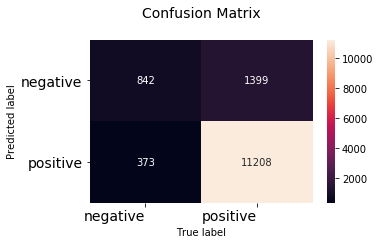

In [ ]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, predictions_w2v_test), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

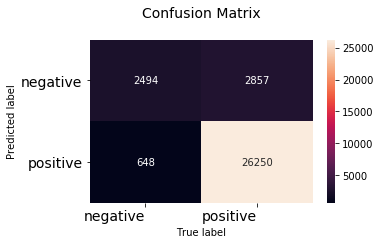

In [ ]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_1, predictions_w2v_train), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

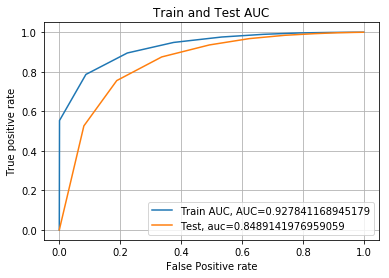

In [ ]:
fpr1, tpr1, _ = metrics.roc_curve(y_1, predict_w2v_train[:,1])

auc_w2v_train = metrics.auc(fpr1,tpr1)

fpr2, tpr2, _ = metrics.roc_curve(y_test,  predict_w2v_test[:,1])

auc_w2v_test = metrics.auc(fpr2,tpr2)

plt.plot(fpr1,tpr1,label="Train AUC, AUC="+str(auc_w2v_train))
plt.plot(fpr2,tpr2,label="Test, auc="+str(auc_w2v_test))
plt.legend(loc=4)
plt.title("Train and Test AUC")
plt.grid()
plt.xlabel('False Positive rate')
plt.ylabel('True positive rate')
plt.show

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [ ]:
# Please write all the code with proper documentation

In [64]:

model = TfidfVectorizer()
tf_idf_matrix_train_w2v = model.fit_transform(X_1)
tf_idf_matrix_train_w2v = model.fit_transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [65]:
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_w2v_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 13547/13547 [01:49<00:00, 123.57it/s]


In [66]:
tfidf_w2v_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 5807/5807 [00:48<00:00, 120.90it/s]


In [ ]:
auc_test_tfw2v=[]
auc_train_tfw2v=[]
k_tfw2v=list(range(1,30,4))
for i in k_tfw2v:
    # instantiate learning model (k = 30)
    knn_tfw2v = KNeighborsClassifier(n_neighbors=i, algorithm='brute')
    knn_tfw2v.fit(tfidf_w2v_sent_vectors_train, y_1)
    pred_test_tfw2v = knn_tfw2v.predict_proba(tfidf_w2v_sent_vectors_test)[:,1]
    auc_test_tfw2v.append(roc_auc_score(y_test,pred_test_tfw2v)) 
    auc_test_tfw2v_v=(roc_auc_score(y_test,pred_test_tfw2v))   
    
    pred_train_tfw2v=knn_tfw2v.predict_proba(tfidf_w2v_sent_vectors_train)[:,1]    
    auc_train_tfw2v_v=(roc_auc_score(y_1,pred_train_tfw2v))
    auc_train_tfw2v.append(roc_auc_score(y_1,pred_train_tfw2v))
    print("\n K  value: ",i, "AUC Test: ",auc_test_tfw2v_v," AUC Train ",auc_train_tfw2v_v)
    


 K  value:  1 AUC Test:  0.6621944898052523  AUC Train  0.999626238086339

 K  value:  5 AUC Test:  0.7896256085177906  AUC Train  0.9342386909056368

 K  value:  9 AUC Test:  0.8185947601244572  AUC Train  0.9133381145066269

 K  value:  13 AUC Test:  0.8313012962922506  AUC Train  0.9040762969262578

 K  value:  17 AUC Test:  0.8377375412288226  AUC Train  0.8990067601605038

 K  value:  21 AUC Test:  0.8415444390847601  AUC Train  0.895593886462336

 K  value:  25 AUC Test:  0.8447287311947229  AUC Train  0.8921918964365182

 K  value:  29 AUC Test:  0.8476881939871278  AUC Train  0.8899578568087788


In [ ]:
best_k_tfw2v=9
knn_tfw2v_9 = KNeighborsClassifier(n_neighbors=best_k_bow,n_jobs=-1)
knn_tfw2v_9.fit(tfidf_w2v_sent_vectors_train, y_1)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=22, p=2,
           weights='uniform')

In [ ]:
predictions_tfw2v_test=knn_tfw2v_9.predict(tfidf_w2v_sent_vectors_test)
predictions_tfw2v_train=knn_tfw2v_9.predict(tfidf_w2v_sent_vectors_train)
predict_tfw2v_test=knn_tfw2v_9.predict_proba(tfidf_w2v_sent_vectors_test)
predict_tfw2v_train=knn_tfw2v_9.predict_proba(tfidf_w2v_sent_vectors_train)



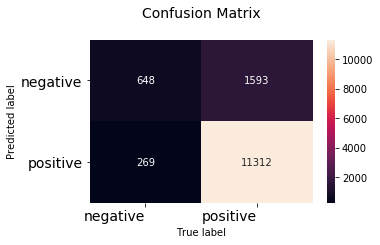

In [ ]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, predictions_tfw2v_test), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

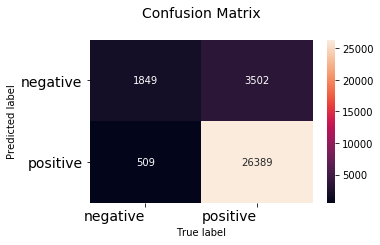

In [ ]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_1, predictions_tfw2v_train), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

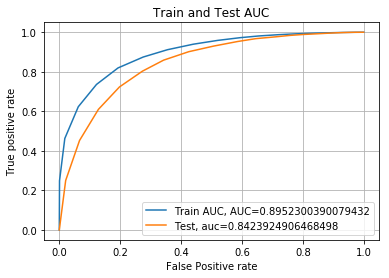

In [ ]:
fpr1, tpr1, _ = metrics.roc_curve(y_1, predict_tfw2v_train[:,1])

auc_avgtf_train = metrics.auc(fpr1,tpr1)

fpr2, tpr2, _ = metrics.roc_curve(y_test,  predict_tfw2v_test[:,1])

auc_avgtf_test = metrics.auc(fpr2,tpr2)

plt.plot(fpr1,tpr1,label="Train AUC, AUC="+str(auc_avgtf_train))
plt.plot(fpr2,tpr2,label="Test, auc="+str(auc_avgtf_test))
plt.legend(loc=4)
plt.title("Train and Test AUC")
plt.grid()
plt.xlabel('False Positive rate')
plt.ylabel('True positive rate')
plt.show

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [ ]:
# Please write all the code with proper documentation

In [26]:
from sklearn import cross_validation
labels = final['Score'] 
df = labels
X=preprocessed_reviews
y = np.array(df)
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

In [27]:
count_vect = CountVectorizer() #in scikit-learn
bow_X_tr=count_vect.fit_transform(X_1)
bow_X_test=count_vect.transform(X_test)
bow_X_tr_kd = bow_X_tr.todense()


In [28]:
bow_X_test_kd = bow_X_test.todense()

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
auc_test_bow_kd=[]
auc_train_bow_kd=[]
k_bow_kd=list(range(1,30,3))
for i in k_bow_kd:
    # instantiate learning model (k = 30)
    knn_bow_kd = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree' ,n_jobs=4)

    # fitting the model on crossvalidation train
    knn_bow_kd.fit(bow_X_tr_kd, y_1)
   
    pred_test_bow_kd = knn_bow_kd.predict_proba(bow_X_test_kd)[:,1]
    auc_test_bow_kd.append(roc_auc_score(y_test,pred_test_bow_kd))
    auc_test_bow_kd_v=(roc_auc_score(y_test,pred_test_bow_kd))
   
    pred_train_bow_kd=knn_bow_kd.predict_proba(bow_X_tr_kd)[:,1]
    auc_train_bow_kd_v=(roc_auc_score(y_1,pred_train_bow_kd))
    auc_train_bow_kd.append(roc_auc_score(y_1,pred_train_bow_kd))
    
    print("\n K  value: ",i, "AUC Test: ",auc_test_bow_kd_v," AUC Train ",auc_train_bow_kd_v)


 K  value:  1 AUC Test:  0.5591959915617553  AUC Train  0.9997637051039698

 K  value:  4 AUC Test:  0.6116103603297334  AUC Train  0.9140733692861533

 K  value:  7 AUC Test:  0.6187927952184488  AUC Train  0.8822363580678614

 K  value:  10 AUC Test:  0.628784767644571  AUC Train  0.853831359158485

 K  value:  13 AUC Test:  0.6228808066193261  AUC Train  0.8415810057187045

 K  value:  16 AUC Test:  0.6186457061318698  AUC Train  0.8320524155866406

 K  value:  19 AUC Test:  0.6216218237596243  AUC Train  0.8312562768738675

 K  value:  22 AUC Test:  0.6265368429831933  AUC Train  0.8325919187352271

 K  value:  25 AUC Test:  0.6254204164184963  AUC Train  0.8277542091539953

 K  value:  28 AUC Test:  0.6296592564590013  AUC Train  0.8229517236566436


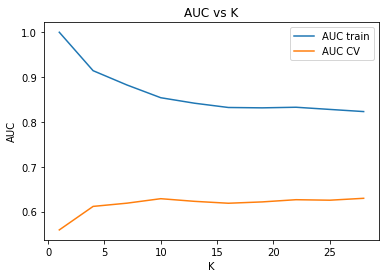

In [30]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(k_bow_kd, auc_train_bow_kd, label='AUC train')
ax.plot(k_bow_kd, auc_test_bow_kd, label='AUC CV')
plt.title('AUC vs K')
plt.xlabel('K')
plt.ylabel('AUC')
ax.legend()
plt.show()

In [32]:
best_k_bow_kd=22
knn_bow_22_kd = KNeighborsClassifier(n_neighbors=best_k_bow_kd,n_jobs=-1)
knn_bow_22_kd.fit(bow_X_tr_kd, y_1)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=22, p=2,
           weights='uniform')

In [34]:
predictions_bow_test_kd=knn_bow_22_kd.predict(bow_X_test_kd)
predictions_bow_train_kd=knn_bow_22_kd.predict(bow_X_tr_kd)
predict_bow_test_kd=knn_bow_22_kd.predict_proba(bow_X_test_kd)
predict_train_bow_kd=knn_bow_22_kd.predict_proba(bow_X_tr_kd)

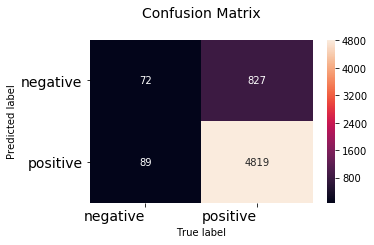

In [35]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, predictions_bow_test_kd), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

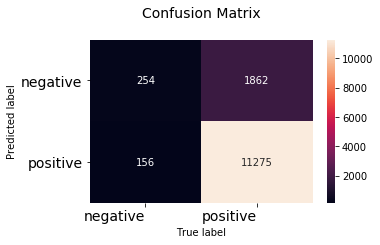

In [36]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_1, predictions_bow_train_kd), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()


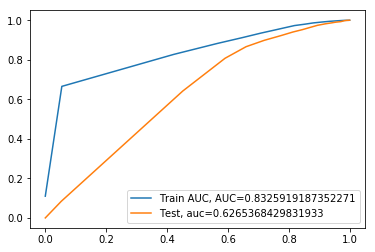

In [37]:
fpr1, tpr1, _ = metrics.roc_curve(y_1, predict_train_bow_kd[:,1])
#df = pd.DataFrame(dict(fpr=fpr1, tpr=tpr1))
auc_bow_train_kd = metrics.auc(fpr1,tpr1)

fpr2, tpr2, _ = metrics.roc_curve(y_test,  predict_bow_test_kd[:,1])
#df1 = pd.DataFrame(dict(fpr=fpr2, tpr=tpr2))
auc_bow_test_kd = metrics.auc(fpr2,tpr2)


plt.plot(fpr1,tpr1,label="Train AUC, AUC="+str(auc_bow_train_kd))
plt.plot(fpr2,tpr2,label="Test, auc="+str(auc_bow_test_kd))
plt.legend(loc=4)

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [ ]:
# Please write all the code with proper documentation

In [38]:
labels = final['Score'] 
df = labels
X=preprocessed_reviews
y = np.array(df)
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)


In [39]:
tf_idf_vect = TfidfVectorizer()
tf_X_tr=tf_idf_vect.fit_transform(X_1)
tf_X_test=tf_idf_vect.transform(X_test)
tf_X_tr_kd = tf_X_tr.todense()

In [40]:
tf_X_test_kd = tf_X_test.todense()

In [41]:
auc_test_tf_kd=[]
auc_train_tf_kd=[]
k_tf_kd=list(range(1,30,3))
for i in k_tf_kd:
    # instantiate learning model (k = 30)
    knn_tf_kd = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree' ,n_jobs=4)

    # fitting the model on crossvalidation train
    knn_tf_kd.fit(tf_X_tr_kd, y_1)
    pred_test_tf_kd = knn_tf_kd.predict_proba(tf_X_test_kd)[:,1]
    auc_test_tf_kd.append(roc_auc_score(y_test,pred_test_tf_kd))
    auc_test_tf_kd_v=(roc_auc_score(y_test,pred_test_tf_kd))
    pred_train_tf_kd=knn_tf_kd.predict_proba(tf_X_tr_kd)[:,1]
    auc_train_tf_kd_v=(roc_auc_score(y_1,pred_train_tf_kd))
    auc_train_tf_kd.append(roc_auc_score(y_1,pred_train_tf_kd))
    
    
 #   print("\n K  value: ",i, "AUC Test: ",auc_test_bow," AUC Train ",auc_train_bow)
    print("\n K  value: ",i, "AUC Test: ",auc_test_tf_kd_v," AUC Train ",auc_train_tf_kd_v)


 K  value:  1 AUC Test:  0.5088214923219043  AUC Train  0.9997637051039698

 K  value:  4 AUC Test:  0.5098487362123812  AUC Train  0.9684543729873281

 K  value:  7 AUC Test:  0.5089123747929648  AUC Train  0.9554109608749729

 K  value:  10 AUC Test:  0.5006070541115591  AUC Train  0.9024885525861671

 K  value:  13 AUC Test:  0.5032877470484728  AUC Train  0.8846497866131613

 K  value:  16 AUC Test:  0.5037328671810478  AUC Train  0.8746233255537169

 K  value:  19 AUC Test:  0.5139776560572147  AUC Train  0.888276172197151

 K  value:  22 AUC Test:  0.5158499256168902  AUC Train  0.909535581203172

 K  value:  25 AUC Test:  0.508593832865096  AUC Train  0.9564474874231004

 K  value:  28 AUC Test:  0.507955955770833  AUC Train  0.9669385177672428


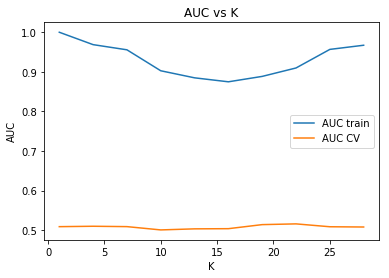

In [42]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(k_tf_kd, auc_train_tf_kd, label='AUC train')
ax.plot(k_tf_kd, auc_test_tf_kd, label='AUC CV')
plt.title('AUC vs K')
plt.xlabel('K')
plt.ylabel('AUC')
ax.legend()
plt.show()

In [43]:
best_k_tf_kd=22
knn_tf_9_kd = KNeighborsClassifier(n_neighbors=best_k_tf_kd,n_jobs=5)
knn_tf_9_kd.fit(tf_X_tr_kd, y_1)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=5, n_neighbors=19, p=2,
           weights='uniform')

In [44]:
predictions_tf_test_kd=knn_tf_9_kd.predict(tf_X_test_kd)
predictions_tf_train_kd=knn_tf_9_kd.predict(tf_X_tr_kd)
predict_tf_test_kd=knn_tf_9_kd.predict_proba(tf_X_test_kd)
predict_tf_train_kd=knn_tf_9_kd.predict_proba(tf_X_tr_kd)

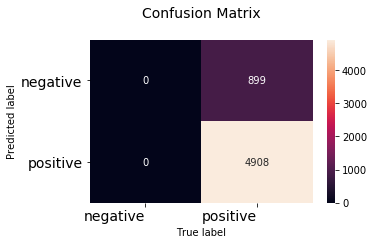

In [45]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, predictions_tf_test_kd), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

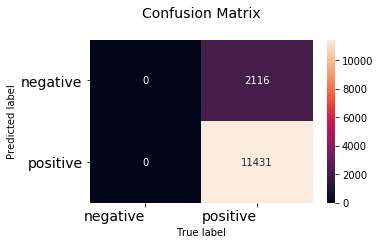

In [46]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_1, predictions_tf_train_kd), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

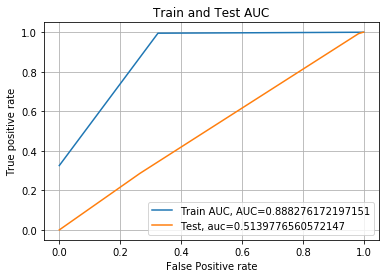

In [47]:
fpr1, tpr1, _ = metrics.roc_curve(y_1, predict_tf_train_kd[:,1])

auc_tf_train_kd = metrics.auc(fpr1,tpr1)

fpr2, tpr2, _ = metrics.roc_curve(y_test,  predict_tf_test_kd[:,1])

auc_tf_test_kd = metrics.auc(fpr2,tpr2)

plt.plot(fpr1,tpr1,label="Train AUC, AUC="+str(auc_tf_train_kd))
plt.plot(fpr2,tpr2,label="Test, auc="+str(auc_tf_test_kd))
plt.legend(loc=4)
plt.title("Train and Test AUC")
plt.grid()
plt.xlabel('False Positive rate')
plt.ylabel('True positive rate')
plt.show

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

In [ ]:
# Please write all the code with proper documentation

In [55]:
auc_test_w2v_kd=[]
auc_train_w2v_kd=[]
k_w2v_kd=list(range(1,30,4))
for i in k_w2v_kd:
    # instantiate learning model (k = 30)
    knn_w2v_kd = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree' ,n_jobs=4)
    # fitting the model on crossvalidation train
    knn_w2v_kd.fit(sent_vectors_train, y_1)
    pred_test_w2v_kd = knn_w2v_kd.predict_proba(sent_vectors_test)[:,1]
    auc_test_w2v_kd.append(roc_auc_score(y_test,pred_test_w2v_kd)) 
    auc_test_w2v_kd_v=(roc_auc_score(y_test,pred_test_w2v_kd))   
    pred_train_w2v_kd=knn_w2v_kd.predict_proba(sent_vectors_train)[:,1]    
    auc_train_w2v_kd_v=(roc_auc_score(y_1,pred_train_w2v_kd))
    auc_train_w2v_kd.append(roc_auc_score(y_1,pred_train_w2v_kd))
    print("\n K  value: ",i, "AUC Test: ",auc_test_w2v_kd_v," AUC Train ",auc_train_w2v_kd_v)
    


 K  value:  1 AUC Test:  0.6466364873403665  AUC Train  0.9997637051039698

 K  value:  5 AUC Test:  0.7860924662284364  AUC Train  0.9281729871296489

 K  value:  9 AUC Test:  0.8141948674294449  AUC Train  0.9059381355942013

 K  value:  13 AUC Test:  0.8231240135512337  AUC Train  0.894645467942032

 K  value:  17 AUC Test:  0.8300642840501037  AUC Train  0.8904424120129671

 K  value:  21 AUC Test:  0.8311182714108676  AUC Train  0.885078449657425

 K  value:  25 AUC Test:  0.8351484897191754  AUC Train  0.88194805390244

 K  value:  29 AUC Test:  0.8354142246252062  AUC Train  0.8788249344840308


In [56]:
best_k_w2v_kd=21
knn_w2v_9_kd = KNeighborsClassifier(n_neighbors=best_k_w2v_kd,n_jobs=5)
knn_w2v_9_kd.fit(sent_vectors_train, y_1)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=5, n_neighbors=21, p=2,
           weights='uniform')

In [58]:
predictions_w2v_test_kd=knn_w2v_9_kd.predict(sent_vectors_test)
predictions_w2v_train_kd=knn_w2v_9_kd.predict(sent_vectors_train)
predict_w2v_test_kd=knn_w2v_9_kd.predict_proba(sent_vectors_test)
predict_w2v_train_kd=knn_w2v_9_kd.predict_proba(sent_vectors_train)

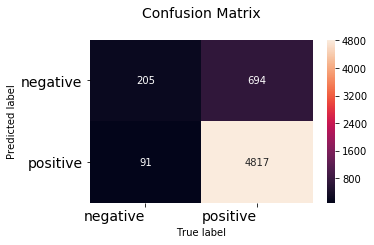

In [59]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_test, predictions_w2v_test_kd), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

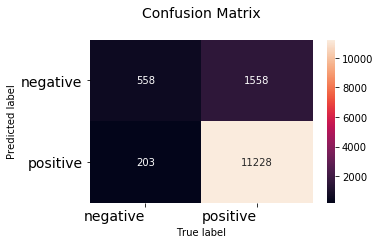

In [60]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_1, predictions_w2v_train_kd), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

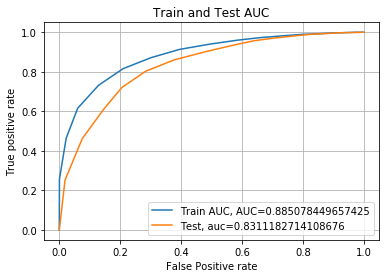

In [61]:
fpr1, tpr1, _ = metrics.roc_curve(y_1, predict_w2v_train_kd[:,1])

auc_w2v_train_kd = metrics.auc(fpr1,tpr1)

fpr2, tpr2, _ = metrics.roc_curve(y_test,  predict_w2v_test_kd[:,1])

auc_w2v_test_kd = metrics.auc(fpr2,tpr2)

plt.plot(fpr1,tpr1,label="Train AUC, AUC="+str(auc_w2v_train_kd))
plt.plot(fpr2,tpr2,label="Test, auc="+str(auc_w2v_test_kd))
plt.legend(loc=4)
plt.title("Train and Test AUC")
plt.grid()
plt.xlabel('False Positive rate')
plt.ylabel('True positive rate')
plt.show

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [ ]:
# Please write all the code with proper documentation

In [70]:
auc_test_tfw2v_kd=[]
auc_train_tfw2v_kd=[]
k_tfw2v_kd=list(range(1,30,4))
for i in k_tfw2v_kd:
    # instantiate learning model (k = 30)
    knn_tfw2v_kd = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree' ,n_jobs=4)
    knn_tfw2v_kd.fit(tfidf_w2v_sent_vectors_train, y_1)
    pred_test_tfw2v_kd = knn_tfw2v_kd.predict_proba(tfidf_w2v_sent_vectors_test)[:,1]
    auc_test_tfw2v_kd.append(roc_auc_score(y_test,pred_test_tfw2v_kd)) 
    auc_test_tfw2v_kd_v=(roc_auc_score(y_test,pred_test_tfw2v_kd))   
    
    pred_train_tfw2v_kd=knn_tfw2v_kd.predict_proba(tfidf_w2v_sent_vectors_train)[:,1]    
    auc_train_tfw2v_kd_v=(roc_auc_score(y_1,pred_train_tfw2v_kd))
    auc_train_tfw2v_kd.append(roc_auc_score(y_1,pred_train_tfw2v_kd))
    print("\n K  value: ",i, "AUC Test: ",auc_test_tfw2v_kd_v," AUC Train ",auc_train_tfw2v_kd_v)


 K  value:  1 AUC Test:  0.6312810892842087  AUC Train  0.9997637051039698

 K  value:  5 AUC Test:  0.7495910288802282  AUC Train  0.9128031731111581

 K  value:  9 AUC Test:  0.7760823626360177  AUC Train  0.88862802027915

 K  value:  13 AUC Test:  0.7903016164841311  AUC Train  0.877594282717758

 K  value:  17 AUC Test:  0.800715365166222  AUC Train  0.8690674084781559

 K  value:  21 AUC Test:  0.8051335904332714  AUC Train  0.8635041530517866

 K  value:  25 AUC Test:  0.8056642670068074  AUC Train  0.858666422799144

 K  value:  29 AUC Test:  0.8063277543734639  AUC Train  0.8555565744264221


In [73]:
best_k_tfw2v_kd=17
knn_tfw2v_9_kd = KNeighborsClassifier(n_neighbors=best_k_tfw2v_kd)
knn_tfw2v_9_kd.fit(tfidf_w2v_sent_vectors_train, y_1)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=17, p=2,
           weights='uniform')

In [74]:
predictions_tfw2v_test_kd =knn_tfw2v_9_kd.predict(tfidf_w2v_sent_vectors_test)
predictions_tfw2v_train_kd =knn_tfw2v_9_kd.predict(tfidf_w2v_sent_vectors_train)
predict_tfw2v_test_kd =knn_tfw2v_9_kd.predict_proba(tfidf_w2v_sent_vectors_test)
predict_tfw2v_train_kd =knn_tfw2v_9_kd.predict_proba(tfidf_w2v_sent_vectors_train)

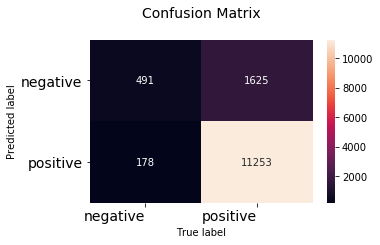

In [75]:
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_1, predictions_tfw2v_train_kd), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()

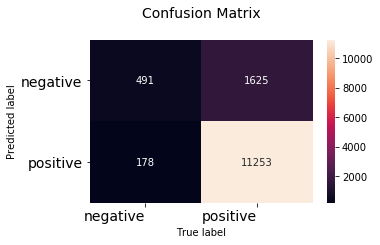

In [76]:

class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(y_1, predictions_tfw2v_train_kd), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=10)
plt.xlabel('True label',size=10)
plt.title("Confusion Matrix\n",size=14)
plt.show()


<function matplotlib.pyplot.show(*args, **kw)>

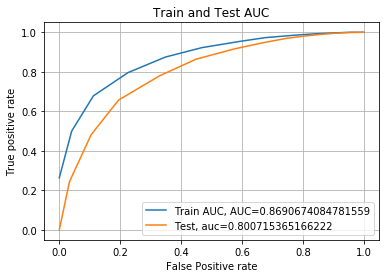

In [77]:

fpr1, tpr1, _ = metrics.roc_curve(y_1, predict_tfw2v_train_kd[:,1])

auc_avgtf_train_kd = metrics.auc(fpr1,tpr1)

fpr2, tpr2, _ = metrics.roc_curve(y_test,  predict_tfw2v_test_kd[:,1])

auc_avgtf_test_kd = metrics.auc(fpr2,tpr2)

plt.plot(fpr1,tpr1,label="Train AUC, AUC="+str(auc_avgtf_train_kd))
plt.plot(fpr2,tpr2,label="Test, auc="+str(auc_avgtf_test_kd))
plt.legend(loc=4)
plt.title("Train and Test AUC")
plt.grid()
plt.xlabel('False Positive rate')
plt.ylabel('True positive rate')
plt.show

# [6] Conclusions

In [ ]:
# Please compare all your models using Prettytable library

In [78]:
from prettytable import PrettyTable

In [93]:
x = PrettyTable()
x.field_names = ["Model", "Optimal K","AUC Score Train","AUC Score Test" ]

x.add_row(["BOW Brute", 22,  0.7875795,0.64740885] )
x.add_row(["BOW KDTREE", 13,  0.8310820, 0.5107593] )
x.add_row(["TFIDF Brute", 9,  0.92784116,   0.8489141976959059] )
x.add_row(["TFIDF KDTREE", 9 ,0.913338,  0.818594760124 ] )
x.add_row(["WORD to Vec Brute ", 22,   0.832591918 , 0.6265368429831] )
x.add_row(["WORD to Vec KDTREE", 22,   0.909535581,0.5158499256] )
x.add_row(["TFIDF to Vec BRUTE", 21, 0.885078449657425,0.8311182714108676] )
x.add_row(["TFIDF to Vec KDTREE", 17,  0.8690674084781559,0.800715365166222] )

print(x)

+---------------------+-----------+--------------------+--------------------+
|        Model        | Optimal K |  AUC Score Train   |   AUC Score Test   |
+---------------------+-----------+--------------------+--------------------+
|      BOW Brute      |     22    |     0.7875795      |     0.64740885     |
|      BOW KDTREE     |     13    |      0.831082      |     0.5107593      |
|     TFIDF Brute     |     9     |     0.92784116     | 0.8489141976959059 |
|     TFIDF KDTREE    |     9     |      0.913338      |   0.818594760124   |
|  WORD to Vec Brute  |     22    |    0.832591918     |  0.6265368429831   |
|  WORD to Vec KDTREE |     22    |    0.909535581     |    0.5158499256    |
|  TFIDF to Vec BRUTE |     21    | 0.885078449657425  | 0.8311182714108676 |
| TFIDF to Vec KDTREE |     17    | 0.8690674084781559 | 0.800715365166222  |
+---------------------+-----------+--------------------+--------------------+


1. Based on the Given Sample Processed Data was used for Analysis
2. Splitting of whole dataset into train_data test_data and CV
3. Different Types of Vecorizerts applied
4. Optimal K was calculated for all types vecorirzer usin auc matric for hyper-parameter tuning or idtenfying best K
5. Based On above mentioned table Best model seems to be TFIDF with Brute Alogrithm
